### Objetivo del ejercicio

Comparar una red convolucional hecha ad-hoc frente a los modelos preentrenados y ajustados con fine tuning y transfer learning. Para ello emplea el dataset de paisajes del conjunto de ejercicios de la unidad anterior.


### Se pide

1. Preparar los datos del modelo y las funciones de visualización, copia para ello todo lo que necesites de las soluciones del ejercicio de clasificación de paisajes de la unidad anterior.

2. Escoger entre uno de los modelos VGG-19, InceptionV3 y MobileNetV2 (todos en https://keras.io/api/applications/) (Se aconseja este último si no tenemos un ordenador muy potente). Si no te haces con estos puedes recurrir a la ResNetV50.

4. Hacer un transfer-learning con una cabeza de como mucho 2 capas densas ocultas y una de salida. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

5. Hacer un fine-tuning con la misma cabeza diseñada en el punto anterior. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

6. Comparar los resultados con los obtenidos con la red convolucional del ejercicio mencionado.

EXTRA:
- Repetir el transfer learning empleando aumentado de imágenes.



In [13]:
# Montar el drive
from google.colab import drive
drive.mount('/content/drive')

# Cargar bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from skimage.io import imread
from sklearn.utils import shuffle
import seaborn as sns
from sklearn.metrics import confusion_matrix
import keras
import cv2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Definir las rutas de los directorios de datos
ROOT_PATH = '/content/drive/MyDrive/datasets/data_paisajes/'
TRAIN_PATH = ROOT_PATH + "seg_train/seg_train"
TEST_PATH = ROOT_PATH + "seg_test/seg_test"

In [4]:
def read_data(directorio, reshape_dim = (32,32)):
    X = []
    y = []
    for folder in os.listdir(directorio):
        print(folder)
        if os.path.isdir('/'.join([directorio, folder])):
            for file in os.listdir('/'.join([directorio, folder])):

                image = imread('/'.join([directorio, folder, file]))
                image = cv2.resize(image, reshape_dim) # Redimensionamos las imágenes a 32x32

                X.append(image)
                y.append(folder)

    return np.array(X),np.array(y)

In [5]:
X_train,y_train = read_data(TRAIN_PATH)
X_test, y_test = read_data(TEST_PATH)

street
sea
glacier
mountain
forest
buildings
sea
glacier
buildings
forest
street


In [6]:


print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (14040, 32, 32, 3)
y_train shape: (14040,)
X_test shape: (3010, 32, 32, 3)
y_test shape: (3010,)


In [7]:
def show_images_batch(paisajes, names = [], n_cols = 5, size_scale = 2):
    n_rows = ((len(paisajes) - 1) // n_cols + 1)
    plt.figure(figsize=(n_cols * size_scale, n_rows * 1.1*size_scale))
    for index, paisaje in enumerate(paisajes):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(paisaje, cmap = "Greys")
        plt.axis("off")
        if len(names):
            plt.title(names[index])

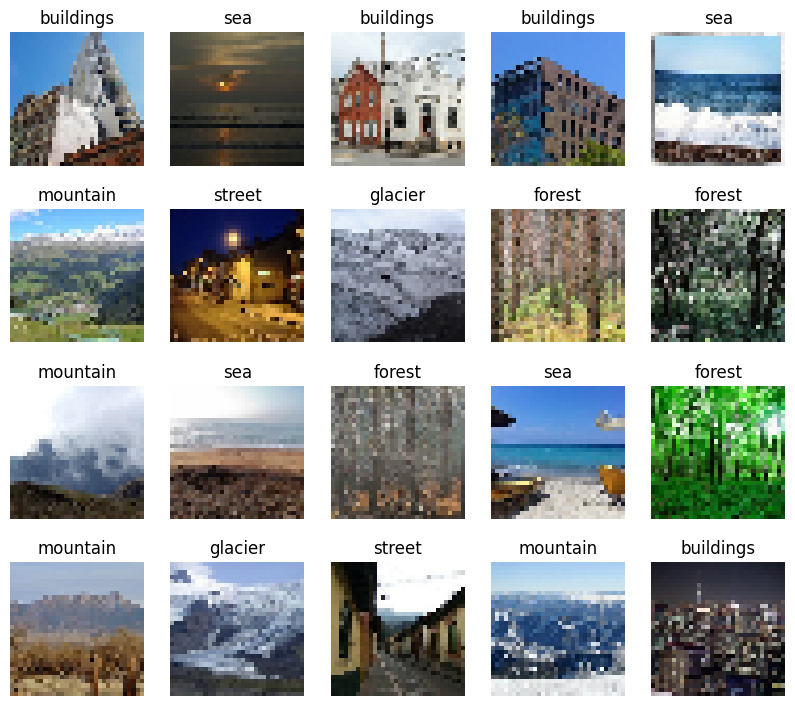

In [8]:
indices = np.random.randint(0,len(X_train),20)
show_images_batch(X_train[indices], names = y_train[indices], n_cols = 5)

In [9]:
targets = pd.Series(y_train)
targets.value_counts(True)

mountain     0.178917
glacier      0.171225
street       0.169658
forest       0.162179
sea          0.161966
buildings    0.156054
Name: proportion, dtype: float64

In [10]:
targets

0           street
1           street
2           street
3           street
4           street
           ...    
14035    buildings
14036    buildings
14037    buildings
14038    buildings
14039    buildings
Length: 14040, dtype: object

In [11]:
X_train = X_train/255
X_test = X_test/255

Primero tendremos que convertir nuestro target a un ordinal

In [12]:
mapa = {tipo:indice for indice,tipo in enumerate(targets.unique())} # Rehusando la serie que creamos para ver la distribución del target
mapa

{'street': 0,
 'sea': 1,
 'glacier': 2,
 'mountain': 3,
 'forest': 4,
 'buildings': 5}

In [14]:
y_train_num = np.array([mapa[y] for y in y_train])
y_test_num = np.array([mapa[y] for y in y_test])

*Además los datos están ordenados, por lo que debemos hacer un shuffle*

In [15]:
# Revolvemos los datos para que el modelo no aprenda en orden de las imágenes
X_train, y_train_num = shuffle(X_train, y_train_num)

Cargamos el modelo MobileNetV2 preentrenado, excluyendo su capa de clasificación superior. Luego, añadimos una nueva cabeza de red con una capa de salida específica para nuestro problema de clasificación de paisajes.

In [22]:
from tensorflow.keras.utils import to_categorical

# Convertir las etiquetas a formato one-hot
y_train_categorical = to_categorical(y_train_num, num_classes=len(mapa))
y_test_categorical = to_categorical(y_test_num, num_classes=len(mapa))


In [23]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

# Cargar el modelo MobileNetV2 sin la parte superior (cabeza)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Congelar las capas base del modelo
base_model.trainable = False

# Añadir una nueva cabeza al modelo
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(mapa), activation='softmax')(x)

# Crear el modelo completo
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Resumen del modelo
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 16, 16, 32)           864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 16, 16, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 16, 16, 32)           0         ['bn_Conv1[0][0]']      

In [24]:
# Entrenar el modelo con las capas base congeladas
history = model.fit(X_train, y_train_categorical, validation_split=0.2, epochs=10, batch_size=32)

# Evaluar el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test, y_test_categorical)
print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')


Epoch 1/10
351/351 [==============================] - 19s 45ms/step - loss: 1.4330 - accuracy: 0.4330 - val_loss: 1.2605 - val_accuracy: 0.4957
Epoch 2/10
351/351 [==============================] - 14s 41ms/step - loss: 1.2738 - accuracy: 0.4924 - val_loss: 1.2238 - val_accuracy: 0.5224
Epoch 3/10
351/351 [==============================] - 14s 40ms/step - loss: 1.2398 - accuracy: 0.5035 - val_loss: 1.2118 - val_accuracy: 0.5260
Epoch 4/10
351/351 [==============================] - 15s 43ms/step - loss: 1.2229 - accuracy: 0.5146 - val_loss: 1.1980 - val_accuracy: 0.5292
Epoch 5/10
351/351 [==============================] - 13s 38ms/step - loss: 1.2027 - accuracy: 0.5203 - val_loss: 1.1932 - val_accuracy: 0.5281
Epoch 6/10
351/351 [==============================] - 15s 44ms/step - loss: 1.1914 - accuracy: 0.5269 - val_loss: 1.1859 - val_accuracy: 0.5367
Epoch 7/10
351/351 [==============================] - 15s 44ms/step - loss: 1.1735 - accuracy: 0.5368 - val_loss: 1.1835 - val_accuracy:

95/95 [==============================] - 4s 25ms/step
              precision    recall  f1-score   support

      street       0.46      0.48      0.47       501
         sea       0.53      0.36      0.43       510
     glacier       0.42      0.43      0.42       553
    mountain       0.44      0.51      0.48       525
      forest       0.74      0.83      0.79       484
   buildings       0.52      0.51      0.51       437

    accuracy                           0.52      3010
   macro avg       0.52      0.52      0.52      3010
weighted avg       0.52      0.52      0.51      3010



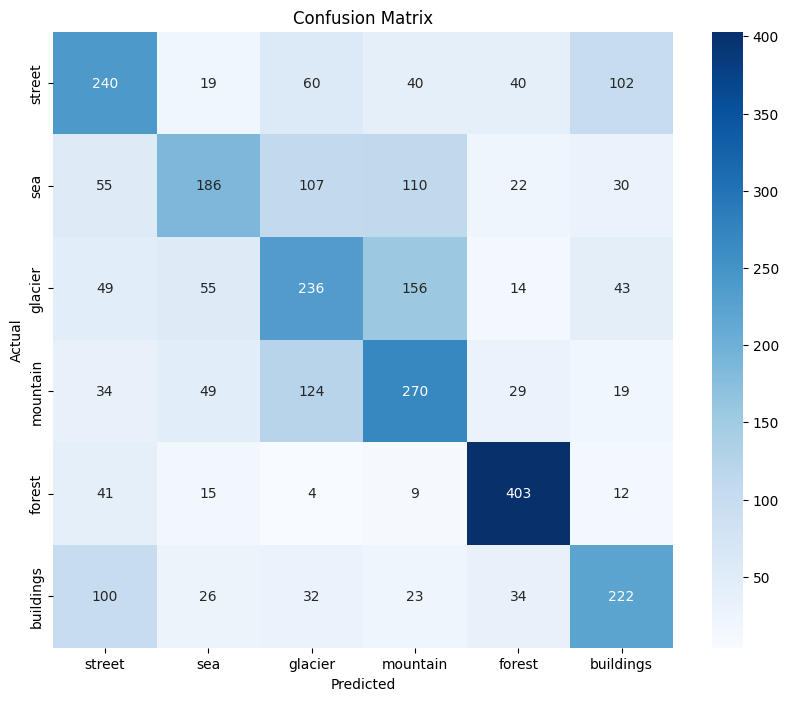

In [25]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predicciones del modelo
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Reporte de clasificación
print(classification_report(y_test_num, y_pred, target_names=mapa.keys()))

# Matriz de confusión
conf_matrix = confusion_matrix(y_test_num, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=mapa.keys(), yticklabels=mapa.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [26]:
# Fine_tunning.Descongelar algunas capas del modelo base
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Compilar el modelo de nuevo con una tasa de aprendizaje más baja
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Reentrenar el modelo con las capas descongeladas
history_finetune = model.fit(X_train, y_train_categorical, validation_split=0.2, epochs=10, batch_size=32)

# Evaluar el modelo en el conjunto de prueba
loss_finetune, accuracy_finetune = model.evaluate(X_test, y_test_categorical)
print(f'Test loss after fine-tuning: {loss_finetune:.4f}')
print(f'Test accuracy after fine-tuning: {accuracy_finetune:.4f}')


Epoch 1/10
351/351 [==============================] - 48s 99ms/step - loss: 8.7950 - accuracy: 0.3352 - val_loss: 1.3888 - val_accuracy: 0.4704
Epoch 2/10
351/351 [==============================] - 31s 89ms/step - loss: 5.7211 - accuracy: 0.4242 - val_loss: 1.6627 - val_accuracy: 0.3462
Epoch 3/10
351/351 [==============================] - 33s 94ms/step - loss: 4.6770 - accuracy: 0.4619 - val_loss: 1.9678 - val_accuracy: 0.2172
Epoch 4/10
351/351 [==============================] - 29s 83ms/step - loss: 3.8080 - accuracy: 0.4953 - val_loss: 1.9979 - val_accuracy: 0.2165
Epoch 5/10
351/351 [==============================] - 33s 94ms/step - loss: 3.4815 - accuracy: 0.5019 - val_loss: 1.9257 - val_accuracy: 0.2550
Epoch 6/10
351/351 [==============================] - 31s 87ms/step - loss: 3.0323 - accuracy: 0.5163 - val_loss: 1.8803 - val_accuracy: 0.2924
Epoch 7/10
351/351 [==============================] - 31s 89ms/step - loss: 2.6328 - accuracy: 0.5443 - val_loss: 1.7918 - val_accuracy:

95/95 [==============================] - 6s 42ms/step
              precision    recall  f1-score   support

      street       0.38      0.57      0.46       501
         sea       0.56      0.28      0.37       510
     glacier       0.42      0.25      0.31       553
    mountain       0.42      0.34      0.38       525
      forest       0.78      0.70      0.74       484
   buildings       0.29      0.54      0.38       437

    accuracy                           0.44      3010
   macro avg       0.48      0.45      0.44      3010
weighted avg       0.48      0.44      0.44      3010



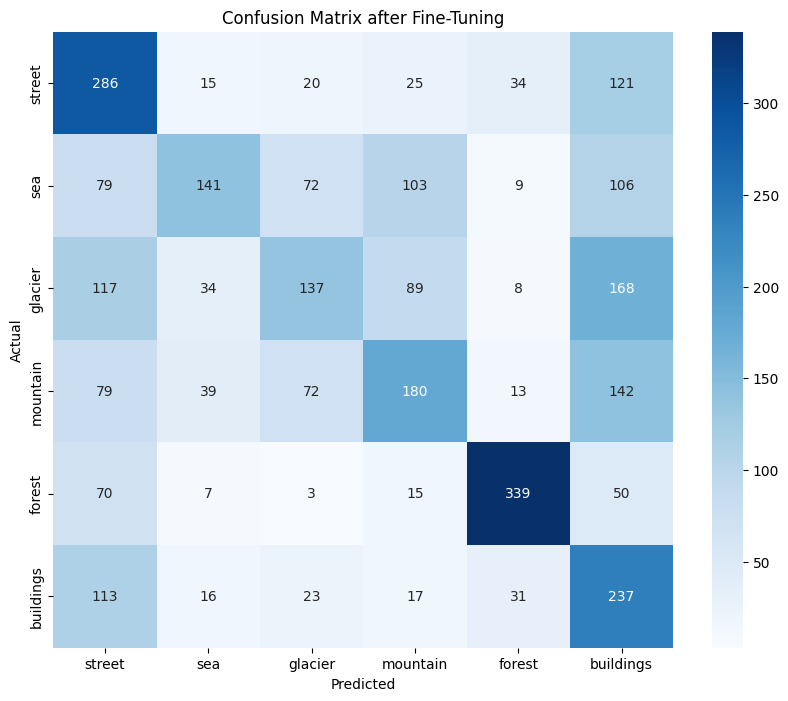

In [27]:
# Predicciones del modelo afinado
y_pred_finetune_prob = model.predict(X_test)
y_pred_finetune = np.argmax(y_pred_finetune_prob, axis=1)

# Reporte de clasificación
print(classification_report(y_test_num, y_pred_finetune, target_names=mapa.keys()))

# Matriz de confusión
conf_matrix_finetune = confusion_matrix(y_test_num, y_pred_finetune)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_finetune, annot=True, fmt='d', cmap='Blues', xticklabels=mapa.keys(), yticklabels=mapa.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix after Fine-Tuning')
plt.show()


Parece que después del fine-tuning el rendimiento del modelo ha disminuido en comparación con el modelo inicial. Vamos a revisar y asegurar que el proceso de fine-tuning se realiza correctamente y que todas las capas se descongelan adecuadamente.

In [28]:
for layer in base_model.layers[-20:]:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 16, 16, 32)           864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 16, 16, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 16, 16, 32)           0         ['bn_Conv1[0][0]']      

In [29]:
# Aplicar aumento de datos y entrenar:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

history_finetune = model.fit(datagen.flow(X_train, y_train_categorical, batch_size=32),
                             validation_data=(X_test, y_test_categorical),
                             epochs=20)


Epoch 1/20
439/439 [==============================] - 50s 103ms/step - loss: 2.7917 - accuracy: 0.4505 - val_loss: 1.5422 - val_accuracy: 0.4654
Epoch 2/20
439/439 [==============================] - 46s 104ms/step - loss: 2.2271 - accuracy: 0.4551 - val_loss: 1.4526 - val_accuracy: 0.5000
Epoch 3/20
439/439 [==============================] - 43s 98ms/step - loss: 1.9706 - accuracy: 0.4596 - val_loss: 1.3671 - val_accuracy: 0.5166
Epoch 4/20
439/439 [==============================] - 47s 106ms/step - loss: 1.7669 - accuracy: 0.4684 - val_loss: 1.3028 - val_accuracy: 0.5379
Epoch 5/20
439/439 [==============================] - 46s 104ms/step - loss: 1.6489 - accuracy: 0.4516 - val_loss: 1.2600 - val_accuracy: 0.5492
Epoch 6/20
439/439 [==============================] - 45s 102ms/step - loss: 1.5285 - accuracy: 0.4660 - val_loss: 1.2043 - val_accuracy: 0.5558
Epoch 7/20
439/439 [==============================] - 45s 103ms/step - loss: 1.4704 - accuracy: 0.4696 - val_loss: 1.1657 - val_acc

95/95 [==============================] - 4s 46ms/step - loss: 0.9741 - accuracy: 0.6379
Test loss after fine-tuning: 0.9741
Test accuracy after fine-tuning: 0.6379
95/95 [==============================] - 5s 41ms/step
              precision    recall  f1-score   support

      street       0.61      0.69      0.65       501
         sea       0.74      0.40      0.52       510
     glacier       0.51      0.60      0.55       553
    mountain       0.60      0.60      0.60       525
      forest       0.81      0.95      0.87       484
   buildings       0.62      0.61      0.61       437

    accuracy                           0.64      3010
   macro avg       0.65      0.64      0.63      3010
weighted avg       0.65      0.64      0.63      3010



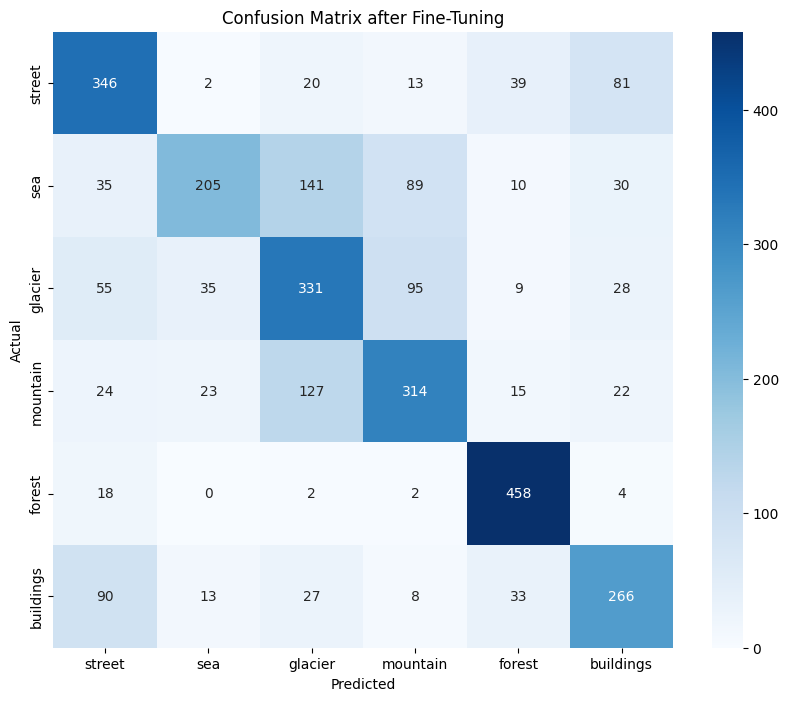

In [30]:
# Evaluación del modelo
loss_finetune, accuracy_finetune = model.evaluate(X_test, y_test_categorical)
print(f'Test loss after fine-tuning: {loss_finetune:.4f}')
print(f'Test accuracy after fine-tuning: {accuracy_finetune:.4f}')

y_pred_finetune_prob = model.predict(X_test)
y_pred_finetune = np.argmax(y_pred_finetune_prob, axis=1)

print(classification_report(y_test_num, y_pred_finetune, target_names=mapa.keys()))

conf_matrix_finetune = confusion_matrix(y_test_num, y_pred_finetune)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_finetune, annot=True, fmt='d', cmap='Blues', xticklabels=mapa.keys(), yticklabels=mapa.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix after Fine-Tuning')
plt.show()


Comparación con los obtenidos con la red convolucional del ejercicio mencionado.
# Precisión y Recall por Categoría
Buildings: La red ad-hoc tiene una mejor precisión (0.74 vs 0.62) y un mejor recall (0.66 vs 0.61) en comparación con MobileNetV2.
Forest: La red ad-hoc tiene una mejor precisión (0.88 vs 0.81) pero similar recall (0.92 vs 0.95).
Glacier: La red ad-hoc supera significativamente a MobileNetV2 en precisión (0.82 vs 0.51) y tiene un recall ligeramente menor (0.60 vs 0.60).
Mountain: La red ad-hoc tiene un recall ligeramente mejor (0.83 vs 0.60) y una precisión ligeramente peor (0.64 vs 0.60).
Sea: MobileNetV2 tiene una mejor precisión (0.74 vs 0.77) pero un recall significativamente menor (0.40 vs 0.71).
Street: La red ad-hoc tiene una mejor precisión (0.75 vs 0.61) y un mejor recall (0.83 vs 0.69).
Exactitud General
Red ad-hoc: 76%
MobileNetV2 después del fine-tuning: 64%
# Conclusiones
Red Convolucional Personalizada (Ad-Hoc): Este modelo ha mostrado un rendimiento superior en términos de precisión y recall en casi todas las categorías en comparación con MobileNetV2, y tiene una exactitud general del 76%.
MobileNetV2 con Fine-Tuning: Aunque este modelo preentrenado tiene la ventaja de ser más rápido y fácil de implementar debido a su preentrenamiento en un conjunto de datos grande y diverso, en este caso específico, su rendimiento no alcanzó el nivel del modelo ad-hoc, con una exactitud general del 64%.